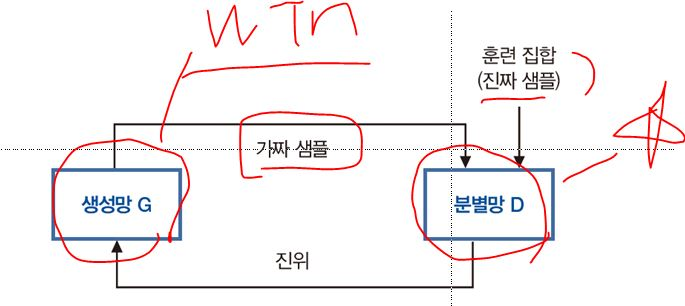

In [56]:
from IPython import display
display.Image('E:/1 강남야간/img/038.jpg',width=500, height=500)

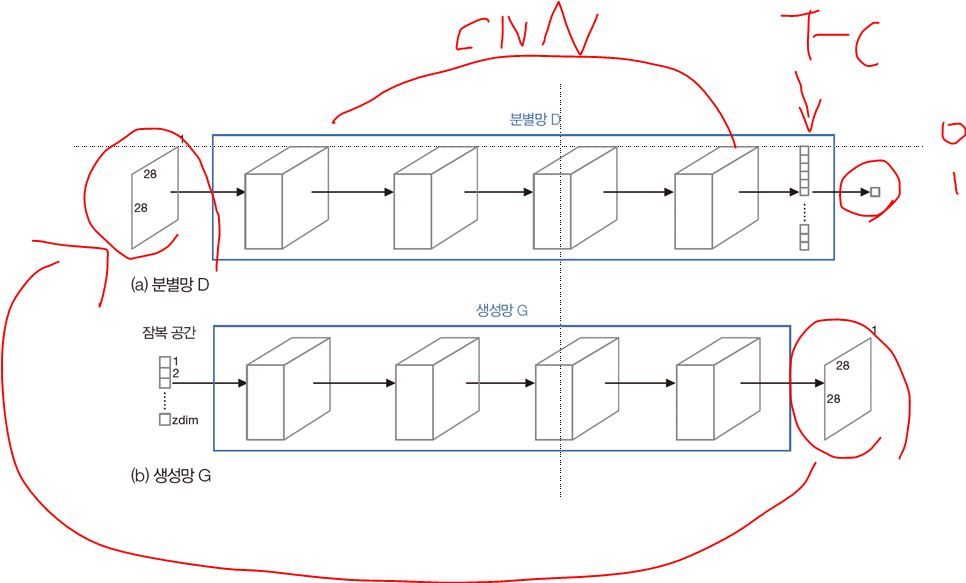

In [57]:
#구조
from IPython import display
display.Image('E:/1 강남야간/img/039.jpg',width=500, height=500)

In [58]:
# MNIST를 가지고 GAN 을 구현하는 프로그램

In [59]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Activation,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose,Dropout,BatchNormalization,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MaxPool2D
import tensorflow as tf

In [60]:
# mnist 데이터를 load
(x_train,y_train),(x_test,y_test) =  mnist.load_data() 

In [61]:
x_train =  (x_train.astype(np.float32)/255.0)*2.0-1.0  # -1  ~ 1
x_test = (x_test.astype(np.float32)/255.0)*2.0-1.0  # -1  ~ 1
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [62]:
batch_size = 64
epoch=5000
dropout_rate = 0.4
batch_norm = 0.9
zdim = 100

In [63]:
discriminator_input=Input(shape=(28, 28, 1)) # 분별망 D 설계
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x=Dropout(dropout_rate)(x)
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(1,1))(x)
x=Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output=Dense(1,activation='sigmoid')(x)
discriminator=Model(discriminator_input,discriminator_output)


In [64]:
discriminator.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 7, 7, 64)          102464    
                                                                 
 dropout_15 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 conv2d_30 (Conv2D)          (None, 4, 4, 128)         204928    
                                                                 
 dropout_16 (Dropout)        (None, 4, 4, 128)         0  

In [65]:
# 생성망 G 설계

In [66]:
generator_input=Input(shape=(zdim,)) # 생성망 G 설계
x=Dense(3136)(generator_input)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Reshape((7,7,64))(x)
x=UpSampling2D()(x)
x=Conv2D(128,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=UpSampling2D()(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(1,(5,5),activation='tanh',padding='same')(x)
generator_output=x
generator=Model(generator_input,generator_output)

In [67]:
discriminator.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [68]:
# 생성망의 학습 설정
discriminator.trainable=False
gan_input=Input(shape=(zdim,))
gan_output=discriminator(generator(gan_input))
gan=Model(gan_input,gan_output)
gan.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [69]:
# 분별망 학습
def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_size)
    real=x_train[c]
    discriminator.train_on_batch(real,np.ones((batch_size,1)))

    p=np.random.normal(0,1,(batch_size,zdim))
    fake=generator.predict(p)
    discriminator.train_on_batch(fake,np.zeros((batch_size,1)))
    

In [70]:
#생성망 학습 함수
def train_generator():
    p=np.random.normal(0,1,(batch_size,zdim))
    gan.train_on_batch(p,np.ones((batch_size,1)))

1/1 [==============================] - 0s 18ms/step


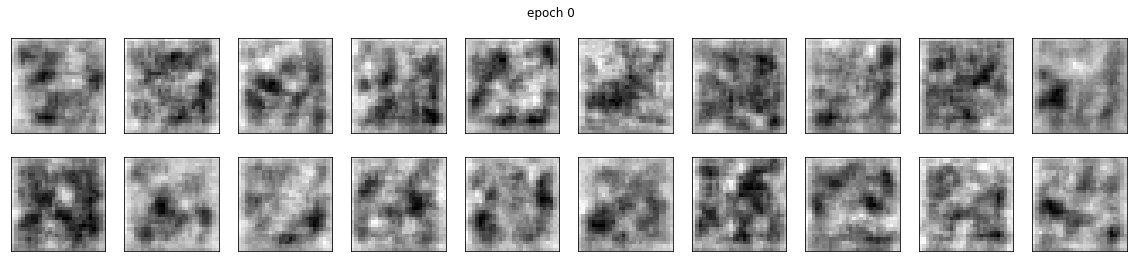

2/2 [==============================] - 0s 79ms/step


In [ ]:
for i in range(epoch+1): # 학습을 수행
    train_discriminator(x_train)
    train_generator()
    if(i%100==0): # 학습 도중 100세대마다 중간 상황 출력
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()
                                   